# Предсказание температуры стали

# Задача

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Нам нужно построить модель, которая предскажет последнюю температуру стали.

# План

**1. Исследовательский анализ данных.** Посмотреть на содержимое датасетов, выявить аномалии, пропуски, определить, какие правки потребуются.

**2. Предобработку данных.** Исправить названия столбцов, обработать пропуски, устранить аномалии. Определить признаки, которые влияют на последнюю температуру и подготовить общую таблицу со всеми необходимыми признаками для обучения модели.

**3. Построение модели.** Обучение разных моделей и оценка их качества, выбор лучшей модели.

**4. Тестирование модели.** Проверить качество лучшей модели на тестовой выборке.

**5. Подготовка отчета.** Описать проделанную работу и полученные результаты.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from catboost import CatBoostRegressor

RANDOM_STATE = 250923

### Обзор данных

#### Данные об электродах

In [2]:
# данные об электродах
data_arc = pd.read_csv('/datasets/data_arc_new.csv')

In [3]:
data_arc.head(5)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [4]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [5]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


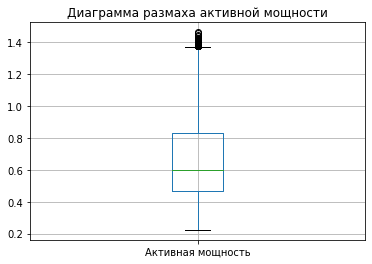

In [6]:
plt.title('Диаграмма размаха активной мощности');
pd.DataFrame(data_arc['Активная мощность']).boxplot(figsize=(8,6));

In [7]:
# вычислим процент аномальных значений в столбце 'Активная мощность'
(data_arc.loc[data_arc['Активная мощность'] > 1.375, 'Активная мощность'].count() / len(data_arc)) * 100

0.47055660123689164

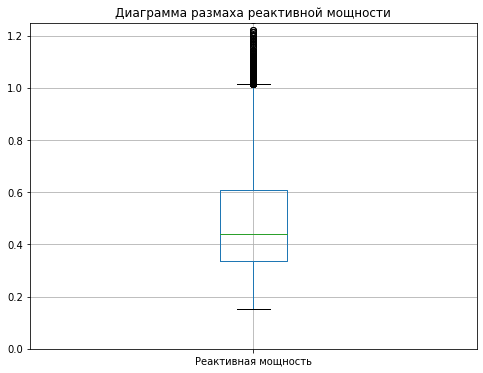

In [8]:
plt.figure(figsize=(8, 6));
plt.ylim(0, 1.25);
plt.title('Диаграмма размаха реактивной мощности');
pd.DataFrame(data_arc['Реактивная мощность']).boxplot();

In [9]:
# вычислим процент аномальных значений в столбце 'Реактивная мощность'
(data_arc.loc[(data_arc['Реактивная мощность'] > 1.015) | (data_arc['Реактивная мощность'] < 0.15), \
              'Реактивная мощность'].count() / len(data_arc)) * 100

1.3377251949448776

Пропусков нет.

Столбцы нужно будет переименовать и привести к нижнему регистру.

Диаграмма размаха показывает, что в столбце "Активная мощность" есть аномальные значения - это значения выше 1,375. Эти данные составляют 0,47% от всех данных, оставим их.

Также для столбца 'Реактивная мощность' диаграмма размаха показывает, что значения ниже 0,15 и выше 1,015 являются аномальными. Эти данные составляют 1.34% от всех данных, оставим их, и удалим только отрицательные значения.

####  Данные о подаче сыпучих материалов (объём)

In [10]:
# данные о подаче сыпучих материалов (объём)
data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')

In [11]:
data_bulk.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [12]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [13]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


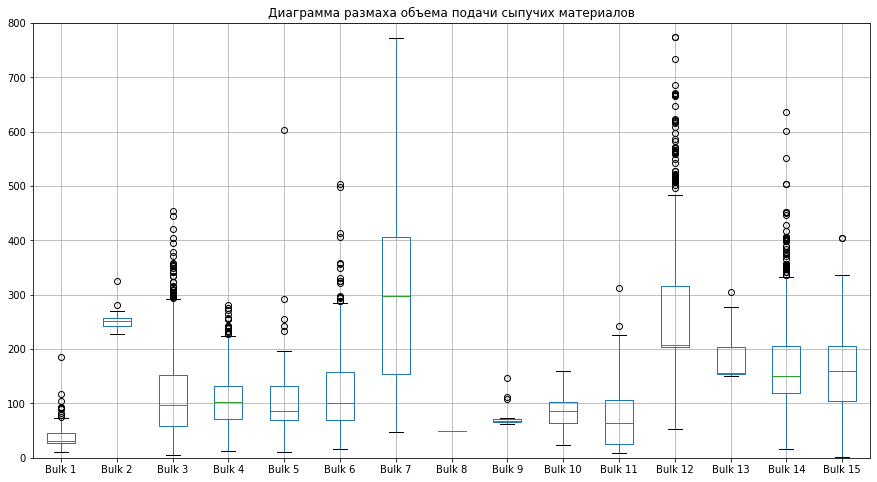

In [14]:
plt.figure(figsize=(15, 8));
plt.ylim(0, 800);
plt.title('Диаграмма размаха объема подачи сыпучих материалов');
data_bulk.drop(['key'], axis=1).boxplot();

Пропуски есть в каждом столбце. Скорее всего их можно бужет заменить значением 0, т.к. NaN возможно означает, материал не был подан, а значит его объем равен 0.

Столбцы нужно привести к нижнему регистру и избавиться от пробовелов.

Диаграмма размаха показывает аномальные значения почти по всем столбцам. Но набор данных не очень большой, поэтому оставим эти значения.

#### Данные о подаче сыпучих материалов (время)

In [15]:
# данные о подаче сыпучих материалов (время)
data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')

In [16]:
data_bulk_time.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [17]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [18]:
data_bulk_time.describe()

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Данные о времени не понадобятся для построения модели, так что с этим датафреймом можно дальше не работать.

#### Данные о продувке сплава газом

In [19]:
# данные о продувке сплава газом
data_gas = pd.read_csv('/datasets/data_gas_new.csv')

In [20]:
data_gas.head(5)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [21]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [22]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


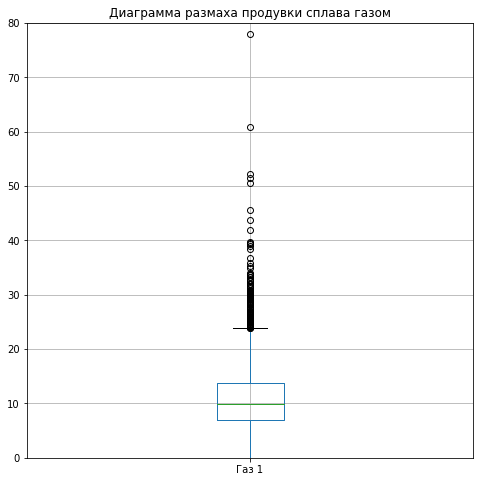

In [23]:
plt.figure(figsize=(8, 8));
plt.ylim(0, 80);
plt.title('Диаграмма размаха продувки сплава газом');
pd.DataFrame(data_gas['Газ 1']).boxplot();

In [24]:
(data_gas.loc[(data_gas['Газ 1'] > 23.9), 'Газ 1'].count() / len(data_gas)) * 100

3.890089533806731

Пропусков нет.

Нужно переименовать столбец.

Диаграмма размаха показывает, что в столбце "Газ 1" есть аномальные значения, они выше 23,9. Таких данных 3,89%. Оставим их.

#### Результаты измерения температуры

In [25]:
# результаты измерения температуры
data_temp = pd.read_csv('/datasets/data_temp_new.csv')

In [26]:
data_temp.head(5)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [27]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [28]:
data_temp.isna().sum() / len(data_temp)

key             0.000000
Время замера    0.000000
Температура     0.189421
dtype: float64

In [29]:
data_temp.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


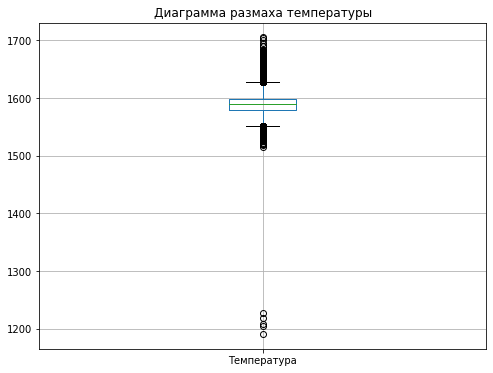

In [30]:
plt.figure(figsize=(8, 6));
plt.title('Диаграмма размаха температуры');
pd.DataFrame(data_temp['Температура']).boxplot();

In [31]:
(data_temp.loc[(data_temp['Температура'] < 1250), 'Температура'].count() / len(data_temp)) * 100

0.0276365244306876

В столбце "Температура" пропусков около 20%. Удалим партии с пропускми.

Нужно переименовать столбцы.

Диаграмма размаха показывает много аномальных значений. Температура плавления стали составляет 1450-1520 градусов. Поэтому удалим значения, которые меньше 1450 градусов.

#### Данные о проволочных материалах (объём)

In [32]:
# данные о проволочных материалах (объём)
data_wire = pd.read_csv('/datasets/data_wire_new.csv')

In [33]:
data_wire.head(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [35]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


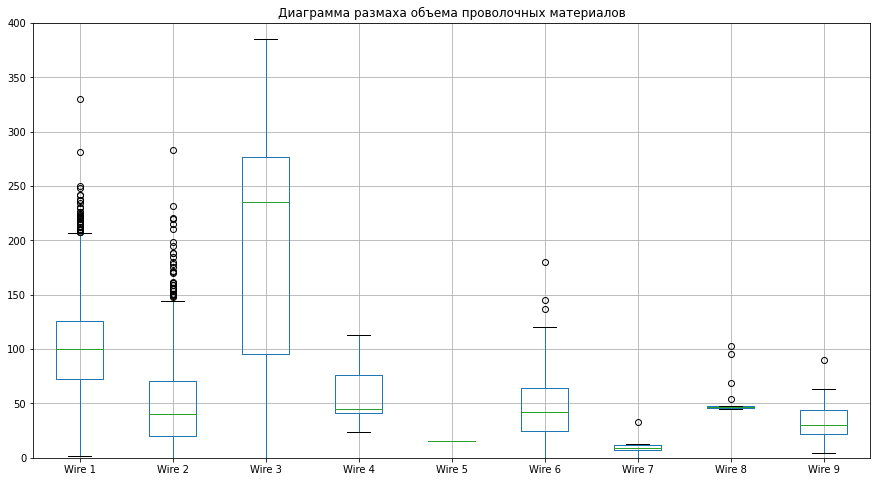

In [36]:
plt.figure(figsize=(15, 8));
plt.ylim(0,400);
plt.title('Диаграмма размаха объема проволочных материалов');
data_wire.drop(['key'], axis=1).boxplot();

Есть много пропусков, которые, скорее всего, означают, что проволочный материал не был использован. В этом случае можно будет заменить пропуски значением 0.

Столбцы нужно привести к нижнему регистру и избавиться от пробовелов.

Диаграмма размаха показывает аномалии почти во всех столбцах, но в большинстве данных очень мало. Поэтому можно убрать самые выбивающиеся значения в в столбцах "Wire 1" и "Wire 2", в них данных достаточно.

#### Данные о проволочных материалах (время)

In [37]:
# данные о проволочных материалах (время)
data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

In [38]:
data_wire_time.head(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Данные о времени не понадобятся для построения модели, так что с этим датафреймом можно дальше не работать.

**Промежуточные выводы**

- требуется обработка пропусков;
- необходимо переименовать столбцы;
- требуется обработка аномалий.

## Предобработка данных

### Удаление аномалий, заполнение пропусков, генерация новых признаков, агрегация по ключу

#### Данные об электродах

In [40]:
#переименуем столбцы
data_arc_clear = data_arc.rename(columns={'Начало нагрева дугой':'start_of_arc_heating', \
                                          'Конец нагрева дугой':'end_of_arc_heating', 'Активная мощность':'active_power', \
                                          'Реактивная мощность':'reactive_power'})
data_arc_clear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   start_of_arc_heating  14876 non-null  object 
 2   end_of_arc_heating    14876 non-null  object 
 3   active_power          14876 non-null  float64
 4   reactive_power        14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [41]:
#удалим аномалии (отрицательные значения)
key = data_arc_clear.loc[data_arc_clear['reactive_power'] < 0, 'key']
data_arc_clear = data_arc_clear.loc[data_arc_clear['key'].values != key.values]
data_arc_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14872 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14872 non-null  int64  
 1   start_of_arc_heating  14872 non-null  object 
 2   end_of_arc_heating    14872 non-null  object 
 3   active_power          14872 non-null  float64
 4   reactive_power        14872 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 697.1+ KB


In [42]:
data_arc_clear.head(5)

,key,start_of_arc_heating,end_of_arc_heating,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [43]:
data_arc_clear['full_power'] = data_arc_clear['active_power']**2 + data_arc_clear['reactive_power']**2
data_arc_clear.head(5)

,key,start_of_arc_heating,end_of_arc_heating,active_power,reactive_power,full_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.137732
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.814179
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.522059
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.413222
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.166258


In [44]:
data_arc_clear['start_of_arc_heating'] = pd.to_datetime(data_arc_clear['start_of_arc_heating'], format='%Y-%m-%d %H:%M:%S')
data_arc_clear['end_of_arc_heating'] = pd.to_datetime(data_arc_clear['end_of_arc_heating'], format='%Y-%m-%d %H:%M:%S')
data_arc_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14872 entries, 0 to 14875
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14872 non-null  int64         
 1   start_of_arc_heating  14872 non-null  datetime64[ns]
 2   end_of_arc_heating    14872 non-null  datetime64[ns]
 3   active_power          14872 non-null  float64       
 4   reactive_power        14872 non-null  float64       
 5   full_power            14872 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 813.3 KB


In [45]:
data_arc_clear['duration_arc'] = data_arc_clear['end_of_arc_heating'] - data_arc_clear['start_of_arc_heating']
data_arc_clear['duration_arc'] = data_arc_clear['duration_arc'].astype('timedelta64[s]')
data_arc_clear.head(5)

,key,start_of_arc_heating,end_of_arc_heating,active_power,reactive_power,full_power,duration_arc
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.137732,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.814179,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.522059,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.413222,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.166258,148.0


In [46]:
data_arc_clear = data_arc_clear.drop(['start_of_arc_heating', 'end_of_arc_heating'], axis=1)
data_arc_clear.head(5)

,key,active_power,reactive_power,full_power,duration_arc
0,1,0.305130,0.211253,0.137732,228.0
1,1,0.765658,0.477438,0.814179,185.0
2,1,0.580313,0.430460,0.522059,172.0
3,1,0.518496,0.379979,0.413222,365.0
4,1,0.867133,0.643691,1.166258,148.0


In [47]:
#агрегируем данные
data_full_power = data_arc_clear.pivot_table(index='key', values=['full_power'], aggfunc=['sum']).reset_index()
data_full_power.head(5)

,key,sum
,,full_power
0,1,3.053450
1,2,1.956857
2,3,5.756776
3,4,3.215134
4,5,2.247989


In [48]:
data_full_power.columns = ['key', 'full_power'] 

In [49]:
data_full_power['full_power'] = data_full_power['full_power']**(1/2)
data_full_power.head(5)

,key,full_power
0,1,1.747412
1,2,1.398877
2,3,2.399328
3,4,1.793079
4,5,1.499330


In [50]:
data_mean_power = data_arc_clear.pivot_table(index='key', values=['active_power', 'reactive_power'], aggfunc=['mean']).reset_index()
data_mean_power.head(5)

key         mean               
      active_power reactive_power
0   1     0.607346       0.428564
1   2     0.534852       0.363339
2   3     0.812728       0.587491
3   4     0.676622       0.514248
4   5     0.563238       0.421998

In [51]:
data_mean_power.columns = ['key', 'mean_active_power', 'mean_reactive_power']
data_mean_power.head(5)

,key,mean_active_power,mean_reactive_power
0,1,0.607346,0.428564
1,2,0.534852,0.363339
2,3,0.812728,0.587491
3,4,0.676622,0.514248
4,5,0.563238,0.421998


In [52]:
data_duration_arc = data_arc_clear.pivot_table(index='key', values=['duration_arc'], aggfunc=['sum']).reset_index()
data_duration_arc.head(5)

,key,sum
,,duration_arc
0,1,1098.0
1,2,811.0
2,3,655.0
3,4,741.0
4,5,869.0


In [53]:
data_duration_arc.columns = ['key', 'sum_duration_arc']
data_duration_arc.head(5)

,key,sum_duration_arc
0,1,1098.0
1,2,811.0
2,3,655.0
3,4,741.0
4,5,869.0


In [54]:
data_arc_clear = data_full_power.merge(data_mean_power, on='key', how='inner')
data_arc_clear.head(5)

,key,full_power,mean_active_power,mean_reactive_power
0,1,1.747412,0.607346,0.428564
1,2,1.398877,0.534852,0.363339
2,3,2.399328,0.812728,0.587491
3,4,1.793079,0.676622,0.514248
4,5,1.499330,0.563238,0.421998


In [55]:
data_arc_clear = data_arc_clear.merge(data_duration_arc, on='key', how='inner')
data_arc_clear.head(5)

,key,full_power,mean_active_power,mean_reactive_power,sum_duration_arc
0,1,1.747412,0.607346,0.428564,1098.0
1,2,1.398877,0.534852,0.363339,811.0
2,3,2.399328,0.812728,0.587491,655.0
3,4,1.793079,0.676622,0.514248,741.0
4,5,1.499330,0.563238,0.421998,869.0


In [56]:
data_arc_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3213 entries, 0 to 3212
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  3213 non-null   int64  
 1   full_power           3213 non-null   float64
 2   mean_active_power    3213 non-null   float64
 3   mean_reactive_power  3213 non-null   float64
 4   sum_duration_arc     3213 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 150.6 KB


####  Данные о подаче сыпучих материалов (объём)

In [57]:
#переименуем столбцы
data_bulk_clear = data_bulk
data_bulk_clear.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', \
       'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']
data_bulk_clear.head(5)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [58]:
data_bulk_clear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [59]:
#заполним пропуски нулями
data_bulk_clear = data_bulk_clear.fillna(value=0)
data_bulk_clear.head(5)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [60]:
data_bulk_clear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   3129 non-null   float64
 2   bulk_2   3129 non-null   float64
 3   bulk_3   3129 non-null   float64
 4   bulk_4   3129 non-null   float64
 5   bulk_5   3129 non-null   float64
 6   bulk_6   3129 non-null   float64
 7   bulk_7   3129 non-null   float64
 8   bulk_8   3129 non-null   float64
 9   bulk_9   3129 non-null   float64
 10  bulk_10  3129 non-null   float64
 11  bulk_11  3129 non-null   float64
 12  bulk_12  3129 non-null   float64
 13  bulk_13  3129 non-null   float64
 14  bulk_14  3129 non-null   float64
 15  bulk_15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [61]:
len(data_bulk_clear['key'].unique())

3129

Все значения ключа уникальны, агрегация не требуется.

#### Данные о продувке сплава газом

In [62]:
data_gas_clear = data_gas.rename(columns={'Газ 1':'gas_1'})
data_gas_clear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [63]:
len(data_gas_clear['key'].unique())

3239

Все значения ключа уникальны, агрегация не требуется.

#### Данные о проволочных материалах (объём)

In [64]:
data_wire.head(1)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
data_wire_clear = data_wire
data_wire_clear.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']
data_wire_clear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [66]:
#заполним пропуски нулями
data_wire_clear = data_wire_clear.fillna(value=0)
data_wire_clear.head(5)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
data_wire_clear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_4  3081 non-null   float64
 5   wire_5  3081 non-null   float64
 6   wire_6  3081 non-null   float64
 7   wire_7  3081 non-null   float64
 8   wire_8  3081 non-null   float64
 9   wire_9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [68]:
len(data_wire_clear['key'].unique())

3081

Все значения ключа уникальны, агрегация не требуется.

#### Результаты измерения температуры

In [69]:
data_temp_clear = data_temp.rename(columns ={'Время замера':'measur_time', 'Температура':'temperature'})
data_temp_clear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          18092 non-null  int64  
 1   measur_time  18092 non-null  object 
 2   temperature  14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [70]:
#избавимся от пропусков
keyt = data_temp_clear.loc[data_temp_clear['temperature'].isna() == True]
keyt = keyt['key'].unique()
data_temp_clear = data_temp_clear.query('key not in @keyt')
data_temp_clear.head(5)

,key,measur_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [71]:
data_temp_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13926 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          13926 non-null  int64  
 1   measur_time  13926 non-null  object 
 2   temperature  13926 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 435.2+ KB


In [72]:
#избавимся от аномально низких значений
key2 = data_temp_clear.loc[data_temp_clear['temperature'] < 1450]
key2 = key2['key'].unique()
data_temp_clear = data_temp_clear.query('key not in @key2')
data_temp_clear.head(5)

,key,measur_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [73]:
data_temp_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13905 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          13905 non-null  int64  
 1   measur_time  13905 non-null  object 
 2   temperature  13905 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 434.5+ KB


In [74]:
data_temp_clear.isna().sum()

key            0
measur_time    0
temperature    0
dtype: int64

In [75]:
#избавимся от партий с одним замером
key3 = data_temp_clear.groupby('key')['key'].count().sort_values()
key3 =[279, 195]
data_temp_clear = data_temp_clear.query('key not in @key3')
data_temp_clear.head(5)

,key,measur_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [76]:
data_temp_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13903 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          13903 non-null  int64  
 1   measur_time  13903 non-null  object 
 2   temperature  13903 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 434.5+ KB


In [77]:
data_count_cycle = data_temp_clear.pivot_table(index='key', values=['temperature'], aggfunc=['count']).reset_index()
data_count_cycle.head(5)

,key,count
,,temperature
0,1,6
1,2,5
2,3,6
3,4,5
4,5,5


In [78]:
data_count_cycle.columns = ['key', 'count_cycle']

In [79]:
data_count_cycle.head(5)

,key,count_cycle
0,1,6
1,2,5
2,3,6
3,4,5
4,5,5


In [80]:
#оставляем только первое и последнее измерение температуры
data_temp_clear = data_temp_clear.groupby('key').agg(['first', 'last']).reset_index()
data_temp_clear.head(5)

key          measur_time                      temperature        
                     first                 last       first    last
0   1  2019-05-03 11:02:04  2019-05-03 11:30:38      1571.0  1613.0
1   2  2019-05-03 11:34:04  2019-05-03 11:55:09      1581.0  1602.0
2   3  2019-05-03 12:06:44  2019-05-03 12:35:57      1596.0  1599.0
3   4  2019-05-03 12:39:27  2019-05-03 12:59:47      1601.0  1625.0
4   5  2019-05-03 13:11:03  2019-05-03 13:36:39      1576.0  1602.0

In [81]:
data_temp_clear.columns = ['key', 'first_measur_time', 'last_measur_time', 'first_temperature', 'last_temperature']
data_temp_clear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2471 entries, 0 to 2470
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2471 non-null   int64  
 1   first_measur_time  2471 non-null   object 
 2   last_measur_time   2471 non-null   object 
 3   first_temperature  2471 non-null   float64
 4   last_temperature   2471 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 96.6+ KB


In [82]:
data_temp_clear['first_measur_time'] = pd.to_datetime(data_temp_clear['first_measur_time'], format='%Y-%m-%d %H:%M:%S')
data_temp_clear['last_measur_time'] = pd.to_datetime(data_temp_clear['last_measur_time'], format='%Y-%m-%d %H:%M:%S')
data_temp_clear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2471 entries, 0 to 2470
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                2471 non-null   int64         
 1   first_measur_time  2471 non-null   datetime64[ns]
 2   last_measur_time   2471 non-null   datetime64[ns]
 3   first_temperature  2471 non-null   float64       
 4   last_temperature   2471 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 96.6 KB


In [83]:
data_temp_clear.head(5)

,key,first_measur_time,last_measur_time,first_temperature,last_temperature
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0


In [84]:
data_temp_clear['duration_temp'] = data_temp_clear['last_measur_time'] - data_temp_clear['first_measur_time']
data_temp_clear['duration_temp'] = data_temp_clear['duration_temp'].astype('timedelta64[s]')
data_temp_clear.head(5)

,key,first_measur_time,last_measur_time,first_temperature,last_temperature,duration_temp
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,1714.0
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,1265.0
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,1753.0
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,1220.0
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,1536.0


In [85]:
data_temp_clear = data_temp_clear.drop(['first_measur_time', 'last_measur_time'], axis=1)
data_temp_clear.head(5)

,key,first_temperature,last_temperature,duration_temp
0,1,1571.0,1613.0,1714.0
1,2,1581.0,1602.0,1265.0
2,3,1596.0,1599.0,1753.0
3,4,1601.0,1625.0,1220.0
4,5,1576.0,1602.0,1536.0


In [86]:
data_temp_clear = data_temp_clear.merge(data_count_cycle, on='key', how='inner')
data_temp_clear.head(5)

,key,first_temperature,last_temperature,duration_temp,count_cycle
0,1,1571.0,1613.0,1714.0,6
1,2,1581.0,1602.0,1265.0,5
2,3,1596.0,1599.0,1753.0,6
3,4,1601.0,1625.0,1220.0,5
4,5,1576.0,1602.0,1536.0,5


In [87]:
data_temp_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 0 to 2470
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2471 non-null   int64  
 1   first_temperature  2471 non-null   float64
 2   last_temperature   2471 non-null   float64
 3   duration_temp      2471 non-null   float64
 4   count_cycle        2471 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 115.8 KB


### Объединение данных в один датафрейм и его исследование

#### Объединение данных

In [88]:
full_data = data_arc_clear.merge(data_bulk_clear, on='key', how='inner')
full_data.head(5)

,key,full_power,mean_active_power,mean_reactive_power,sum_duration_arc,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,1.747412,0.607346,0.428564,1098.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,1.398877,0.534852,0.363339,811.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,2.399328,0.812728,0.587491,655.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,1.793079,0.676622,0.514248,741.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,1.499330,0.563238,0.421998,869.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [89]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3127 entries, 0 to 3126
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  3127 non-null   int64  
 1   full_power           3127 non-null   float64
 2   mean_active_power    3127 non-null   float64
 3   mean_reactive_power  3127 non-null   float64
 4   sum_duration_arc     3127 non-null   float64
 5   bulk_1               3127 non-null   float64
 6   bulk_2               3127 non-null   float64
 7   bulk_3               3127 non-null   float64
 8   bulk_4               3127 non-null   float64
 9   bulk_5               3127 non-null   float64
 10  bulk_6               3127 non-null   float64
 11  bulk_7               3127 non-null   float64
 12  bulk_8               3127 non-null   float64
 13  bulk_9               3127 non-null   float64
 14  bulk_10              3127 non-null   float64
 15  bulk_11              3127 non-null   f

In [90]:
full_data = full_data.merge(data_gas_clear, on='key', how='inner')
full_data.head(5)

,key,full_power,mean_active_power,mean_reactive_power,sum_duration_arc,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas_1
0,1,1.747412,0.607346,0.428564,1098.0,0.0,0.0,0.0,43.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,2,1.398877,0.534852,0.363339,811.0,0.0,0.0,0.0,73.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,3,2.399328,0.812728,0.587491,655.0,0.0,0.0,0.0,34.0,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,4,1.793079,0.676622,0.514248,741.0,0.0,0.0,0.0,81.0,0.0,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,5,1.499330,0.563238,0.421998,869.0,0.0,0.0,0.0,78.0,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692


In [91]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3125 entries, 0 to 3124
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  3125 non-null   int64  
 1   full_power           3125 non-null   float64
 2   mean_active_power    3125 non-null   float64
 3   mean_reactive_power  3125 non-null   float64
 4   sum_duration_arc     3125 non-null   float64
 5   bulk_1               3125 non-null   float64
 6   bulk_2               3125 non-null   float64
 7   bulk_3               3125 non-null   float64
 8   bulk_4               3125 non-null   float64
 9   bulk_5               3125 non-null   float64
 10  bulk_6               3125 non-null   float64
 11  bulk_7               3125 non-null   float64
 12  bulk_8               3125 non-null   float64
 13  bulk_9               3125 non-null   float64
 14  bulk_10              3125 non-null   float64
 15  bulk_11              3125 non-null   f

In [92]:
full_data = full_data.merge(data_wire_clear, on='key', how='inner')
full_data.head(5)

,key,full_power,mean_active_power,mean_reactive_power,sum_duration_arc,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,gas_1,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,1.747412,0.607346,0.428564,1098.0,0.0,0.0,0.0,43.0,0.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1.398877,0.534852,0.363339,811.0,0.0,0.0,0.0,73.0,0.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2.399328,0.812728,0.587491,655.0,0.0,0.0,0.0,34.0,0.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1.793079,0.676622,0.514248,741.0,0.0,0.0,0.0,81.0,0.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1.499330,0.563238,0.421998,869.0,0.0,0.0,0.0,78.0,0.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3021 entries, 0 to 3020
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  3021 non-null   int64  
 1   full_power           3021 non-null   float64
 2   mean_active_power    3021 non-null   float64
 3   mean_reactive_power  3021 non-null   float64
 4   sum_duration_arc     3021 non-null   float64
 5   bulk_1               3021 non-null   float64
 6   bulk_2               3021 non-null   float64
 7   bulk_3               3021 non-null   float64
 8   bulk_4               3021 non-null   float64
 9   bulk_5               3021 non-null   float64
 10  bulk_6               3021 non-null   float64
 11  bulk_7               3021 non-null   float64
 12  bulk_8               3021 non-null   float64
 13  bulk_9               3021 non-null   float64
 14  bulk_10              3021 non-null   float64
 15  bulk_11              3021 non-null   f

In [94]:
full_data = full_data.merge(data_temp_clear, on='key', how='inner')
full_data.head(5)

,key,full_power,mean_active_power,mean_reactive_power,sum_duration_arc,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,first_temperature,last_temperature,duration_temp,count_cycle
0,1,1.747412,0.607346,0.428564,1098.0,0.0,0.0,0.0,43.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1571.0,1613.0,1714.0,6
1,2,1.398877,0.534852,0.363339,811.0,0.0,0.0,0.0,73.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1581.0,1602.0,1265.0,5
2,3,2.399328,0.812728,0.587491,655.0,0.0,0.0,0.0,34.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1596.0,1599.0,1753.0,6
3,4,1.793079,0.676622,0.514248,741.0,0.0,0.0,0.0,81.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1601.0,1625.0,1220.0,5
4,5,1.499330,0.563238,0.421998,869.0,0.0,0.0,0.0,78.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1576.0,1602.0,1536.0,5


In [95]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  2324 non-null   int64  
 1   full_power           2324 non-null   float64
 2   mean_active_power    2324 non-null   float64
 3   mean_reactive_power  2324 non-null   float64
 4   sum_duration_arc     2324 non-null   float64
 5   bulk_1               2324 non-null   float64
 6   bulk_2               2324 non-null   float64
 7   bulk_3               2324 non-null   float64
 8   bulk_4               2324 non-null   float64
 9   bulk_5               2324 non-null   float64
 10  bulk_6               2324 non-null   float64
 11  bulk_7               2324 non-null   float64
 12  bulk_8               2324 non-null   float64
 13  bulk_9               2324 non-null   float64
 14  bulk_10              2324 non-null   float64
 15  bulk_11              2324 non-null   f

#### Исследование данных

In [96]:
full_data.describe()

,key,full_power,mean_active_power,mean_reactive_power,sum_duration_arc,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,first_temperature,last_temperature,duration_temp,count_cycle
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,...,2324.000000,2324.0,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,1251.140275,1.862888,0.664209,0.488921,808.196644,3.435026,1.425559,47.317126,37.347676,2.645869,...,0.307209,0.0,0.980926,0.006374,0.311981,0.317795,1587.368761,1593.372633,2323.682014,5.696644
std,715.027927,0.492693,0.128419,0.098024,340.813828,12.424463,19.102530,75.238050,58.677890,22.426054,...,4.762842,0.0,8.702531,0.205926,4.407419,3.460248,23.627590,11.207457,1385.809791,1.606210
min,1.000000,0.331897,0.267676,0.196228,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1519.000000,1541.000000,339.000000,2.000000
25%,628.750000,1.527493,0.576159,0.420039,581.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1571.000000,1587.000000,1580.500000,5.000000
50%,1254.500000,1.867078,0.655834,0.484669,778.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1587.000000,1593.000000,2046.500000,6.000000
75%,1867.250000,2.189284,0.741883,0.546693,993.000000,0.000000,0.000000,80.000000,77.250000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1603.000000,1598.000000,2793.500000,7.000000
max,2499.000000,4.077987,1.243889,0.960763,4189.000000,185.000000,325.000000,454.000000,281.000000,603.000000,...,113.231044,0.0,180.454575,8.490040,102.762401,62.025600,1660.000000,1653.000000,23674.000000,17.000000


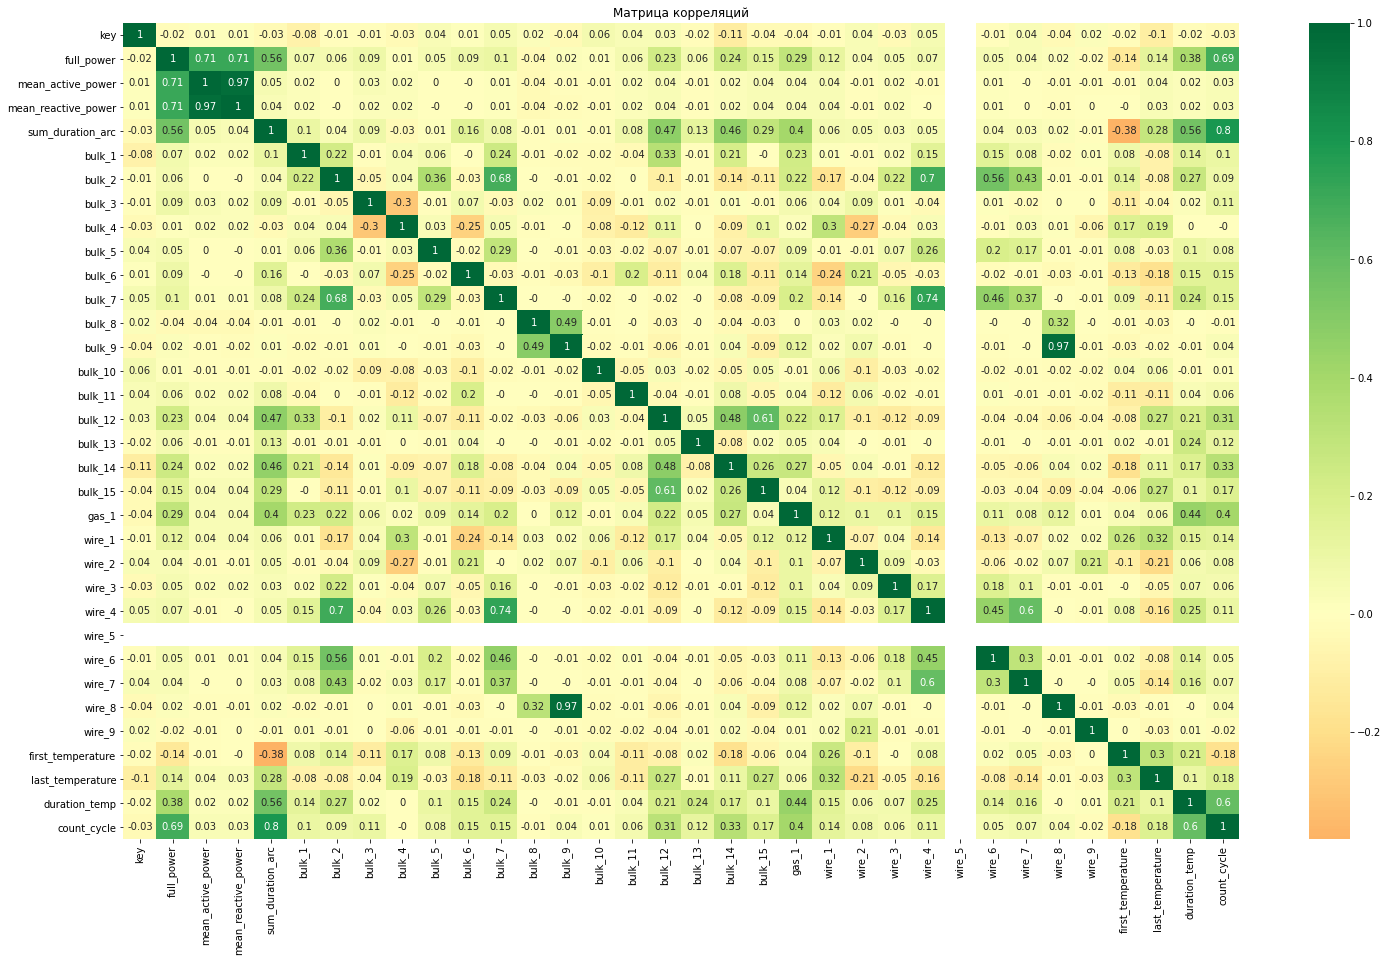

In [97]:
plt.figure(figsize=(25,15));
plt.title('Матрица корреляций');
sns.heatmap(round(full_data.corr(), 2), xticklabels=full_data.corr().columns, yticklabels=full_data.corr().columns, cmap='RdYlGn', center=0, annot=True);

Матрица корреляций показывает, что есть признаки, которые неплохо коррелируют друг с другом, но у признаков bulk 9 и wire 8 корреляция доходит до 0.97, поэтому мы исключим признак bulk 9 для линейной модели.

Также мы исключим признак wire 5, т.к. он не имеет значимости для модели. в данных всего 1 значение. Значение ключа для модели тоже не важно.

In [98]:
full_data = full_data.drop(['key', 'wire_5'], axis=1)
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   full_power           2324 non-null   float64
 1   mean_active_power    2324 non-null   float64
 2   mean_reactive_power  2324 non-null   float64
 3   sum_duration_arc     2324 non-null   float64
 4   bulk_1               2324 non-null   float64
 5   bulk_2               2324 non-null   float64
 6   bulk_3               2324 non-null   float64
 7   bulk_4               2324 non-null   float64
 8   bulk_5               2324 non-null   float64
 9   bulk_6               2324 non-null   float64
 10  bulk_7               2324 non-null   float64
 11  bulk_8               2324 non-null   float64
 12  bulk_9               2324 non-null   float64
 13  bulk_10              2324 non-null   float64
 14  bulk_11              2324 non-null   float64
 15  bulk_12              2324 non-null   f

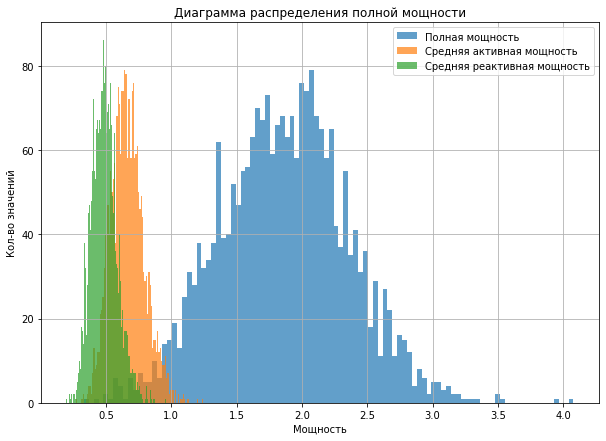

In [99]:
full_data['full_power'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
full_data['mean_active_power'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
full_data['mean_reactive_power'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
plt.xlabel("Мощность");
plt.ylabel("Кол-во значений");
plt.legend(['Полная мощность', 'Средняя активная мощность', 'Средняя реактивная мощность']);
plt.title("Диаграмма распределения полной мощности");

Полная мощность, средняя активная и реактивная мощность имеют нормальное распределение.

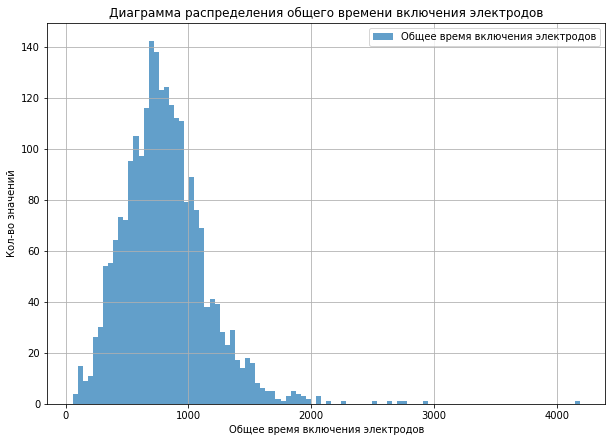

In [100]:
full_data['sum_duration_arc'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
plt.xlabel("Общее время включения электродов");
plt.ylabel("Кол-во значений");
plt.legend(['Общее время включения электродов']);
plt.title("Диаграмма распределения общего времени включения электродов");

Общее время включения электродов в целом имеет нормальное распределение. Есть небольшой скос за счет нескольких больших значений.

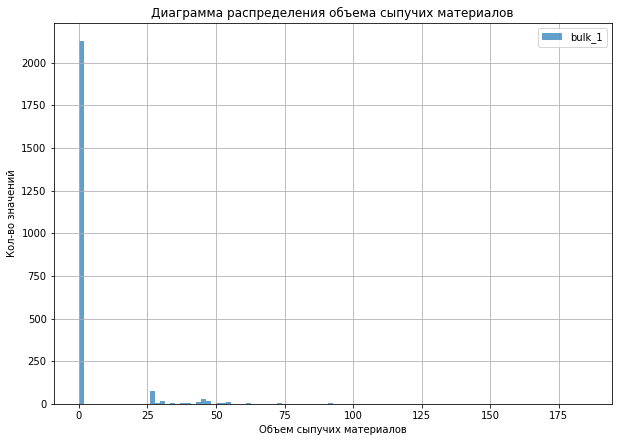

In [101]:
full_data['bulk_1'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
plt.xlabel("Объем сыпучих материалов");
plt.ylabel("Кол-во значений");
plt.legend(['bulk_1']);
plt.title("Диаграмма распределения объема сыпучих материалов");

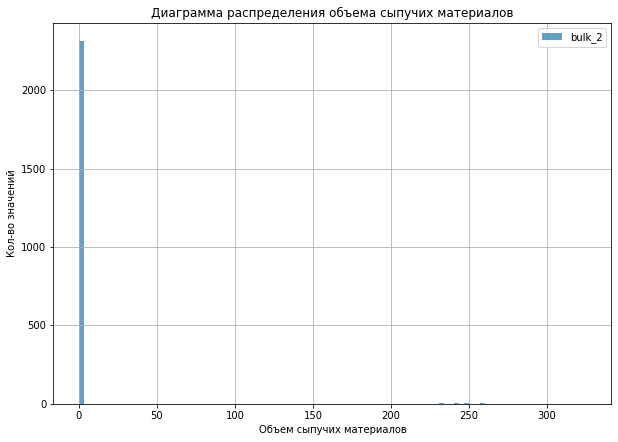

In [102]:
full_data['bulk_2'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
plt.xlabel("Объем сыпучих материалов");
plt.ylabel("Кол-во значений");
plt.legend(['bulk_2']);
plt.title("Диаграмма распределения объема сыпучих материалов");

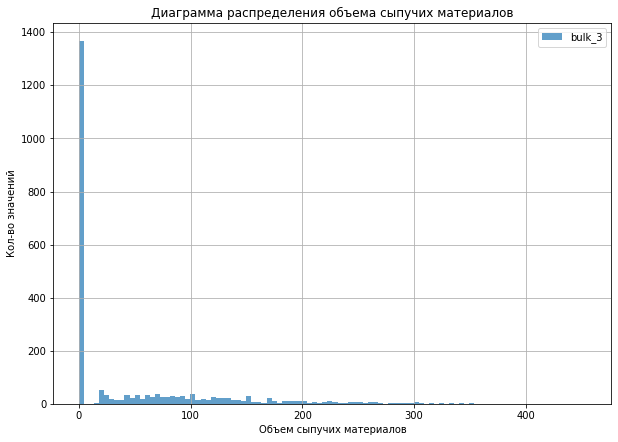

In [103]:
full_data['bulk_3'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
plt.xlabel("Объем сыпучих материалов");
plt.ylabel("Кол-во значений");
plt.legend(['bulk_3']);
plt.title("Диаграмма распределения объема сыпучих материалов");

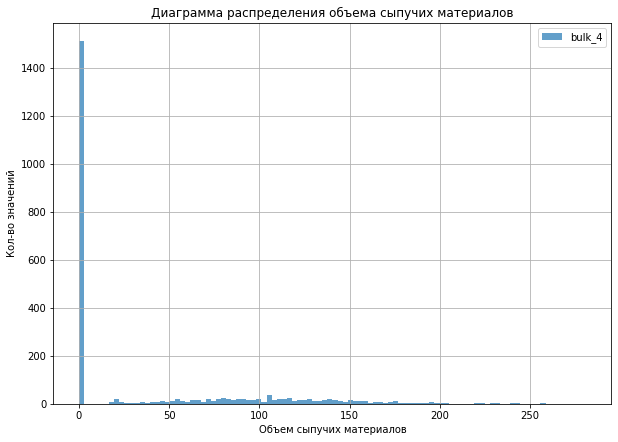

In [104]:
full_data['bulk_4'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
plt.xlabel("Объем сыпучих материалов");
plt.ylabel("Кол-во значений");
plt.legend(['bulk_4']);
plt.title("Диаграмма распределения объема сыпучих материалов");

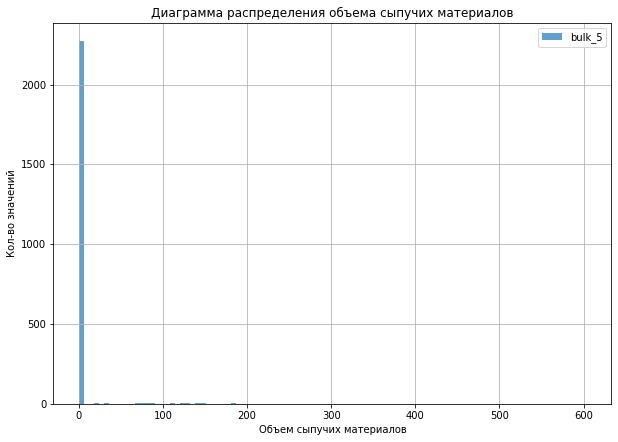

In [105]:
full_data['bulk_5'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
plt.xlabel("Объем сыпучих материалов");
plt.ylabel("Кол-во значений");
plt.legend(['bulk_5']);
plt.title("Диаграмма распределения объема сыпучих материалов");

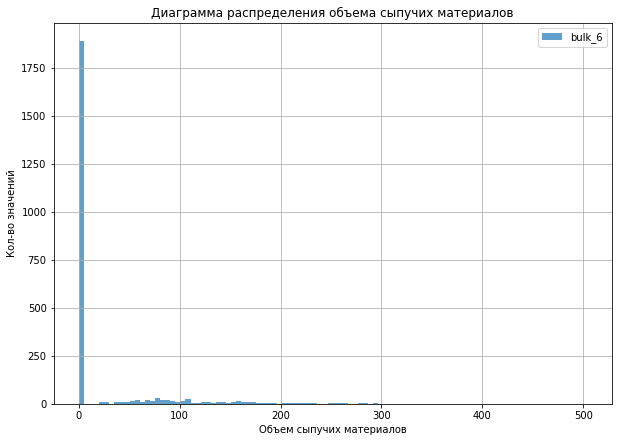

In [106]:
full_data['bulk_6'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
plt.xlabel("Объем сыпучих материалов");
plt.ylabel("Кол-во значений");
plt.legend(['bulk_6']);
plt.title("Диаграмма распределения объема сыпучих материалов");

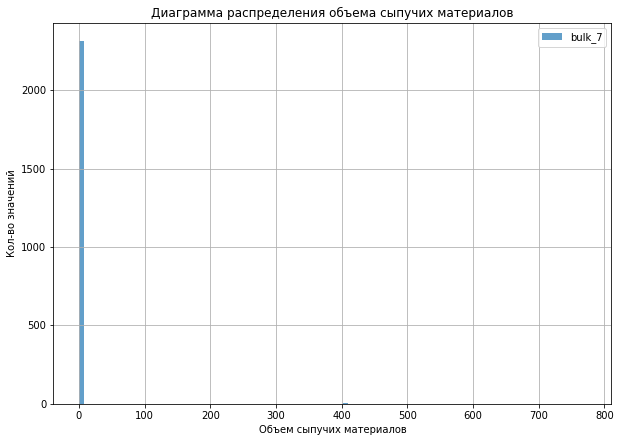

In [107]:
full_data['bulk_7'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
plt.xlabel("Объем сыпучих материалов");
plt.ylabel("Кол-во значений");
plt.legend(['bulk_7']);
plt.title("Диаграмма распределения объема сыпучих материалов");

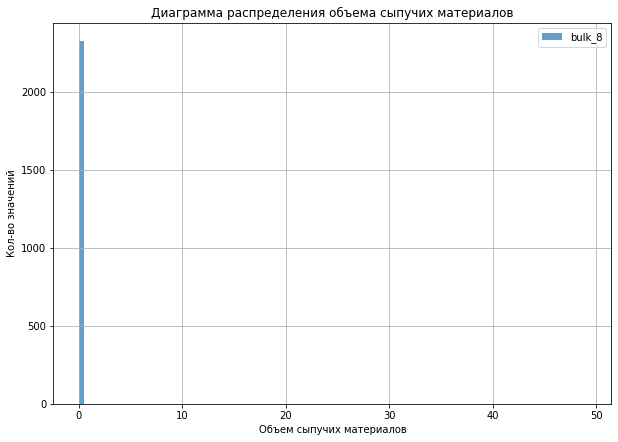

In [108]:
full_data['bulk_8'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
plt.xlabel("Объем сыпучих материалов");
plt.ylabel("Кол-во значений");
plt.legend(['bulk_8']);
plt.title("Диаграмма распределения объема сыпучих материалов");

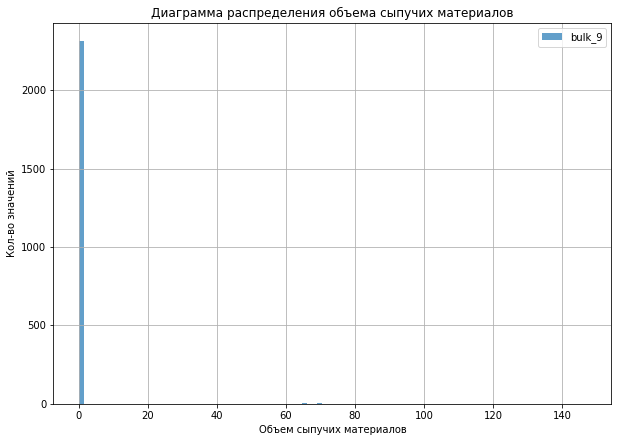

In [109]:
full_data['bulk_9'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
plt.xlabel("Объем сыпучих материалов");
plt.ylabel("Кол-во значений");
plt.legend(['bulk_9']);
plt.title("Диаграмма распределения объема сыпучих материалов");

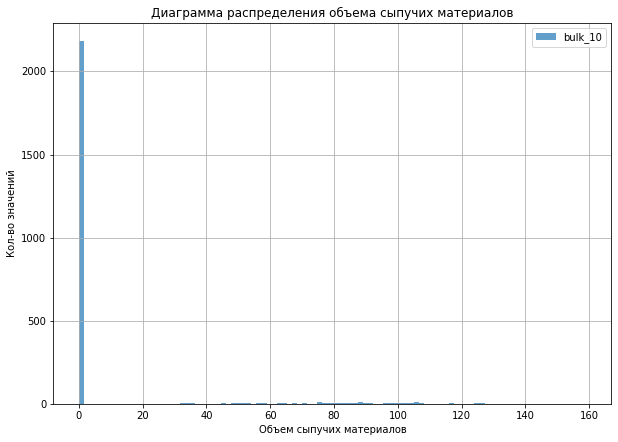

In [110]:
full_data['bulk_10'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
plt.xlabel("Объем сыпучих материалов");
plt.ylabel("Кол-во значений");
plt.legend(['bulk_10']);
plt.title("Диаграмма распределения объема сыпучих материалов");

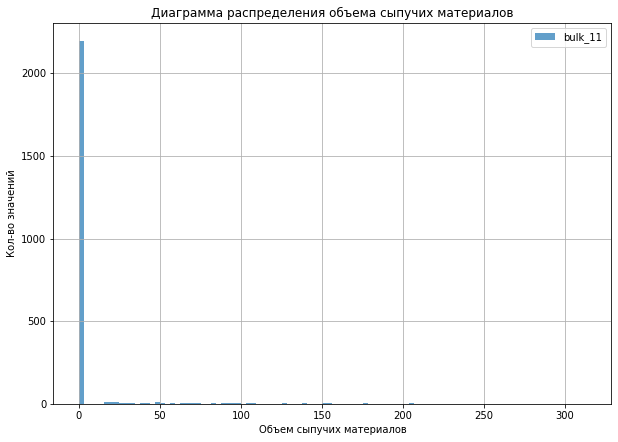

In [111]:
full_data['bulk_11'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
plt.xlabel("Объем сыпучих материалов");
plt.ylabel("Кол-во значений");
plt.legend(['bulk_11']);
plt.title("Диаграмма распределения объема сыпучих материалов");

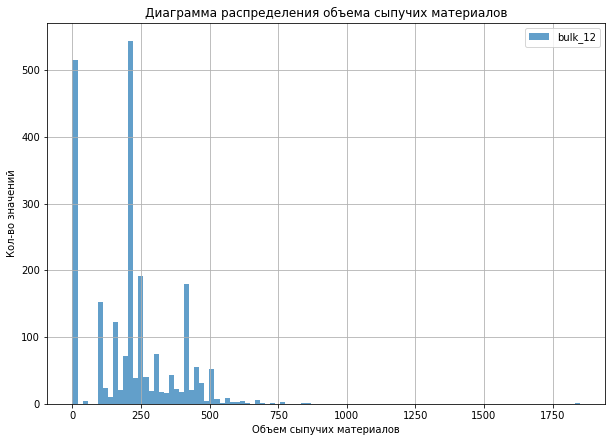

In [112]:
full_data['bulk_12'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
plt.xlabel("Объем сыпучих материалов");
plt.ylabel("Кол-во значений");
plt.legend(['bulk_12']);
plt.title("Диаграмма распределения объема сыпучих материалов");

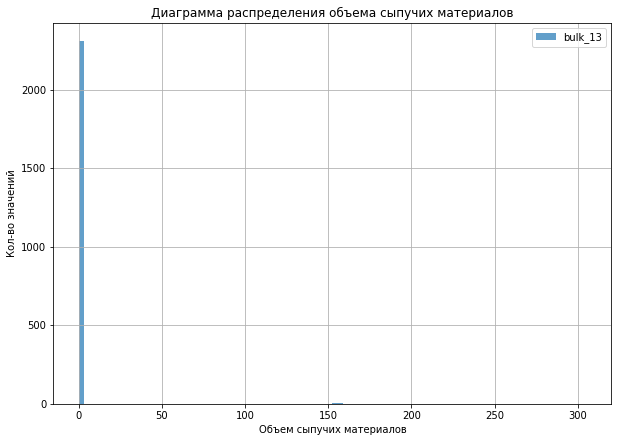

In [113]:
full_data['bulk_13'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
plt.xlabel("Объем сыпучих материалов");
plt.ylabel("Кол-во значений");
plt.legend(['bulk_13']);
plt.title("Диаграмма распределения объема сыпучих материалов");

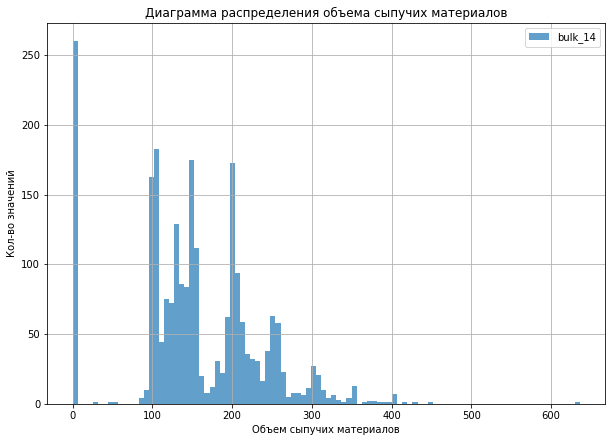

In [114]:
full_data['bulk_14'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
plt.xlabel("Объем сыпучих материалов");
plt.ylabel("Кол-во значений");
plt.legend(['bulk_14']);
plt.title("Диаграмма распределения объема сыпучих материалов");

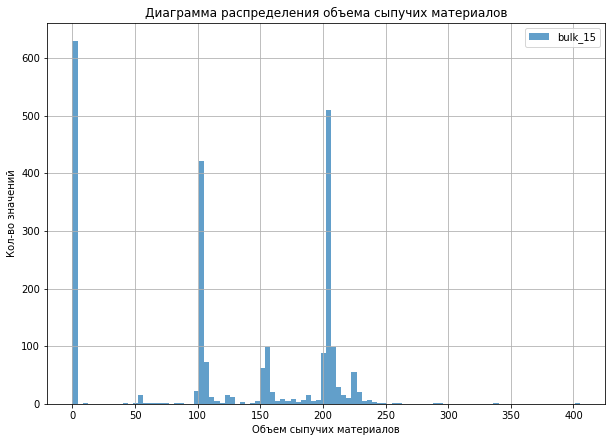

In [115]:
full_data['bulk_15'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
plt.xlabel("Объем сыпучих материалов");
plt.ylabel("Кол-во значений");
plt.legend(['bulk_15']);
plt.title("Диаграмма распределения объема сыпучих материалов");

У признаков bulk_1, bulk_2, bulk_5 , bulk_7, bulk_8, bulk_9, bulk_10, bulk_11, bulk_13 большинство значений нулевый, т.к. эти материалы не добавлялись в сплав.

У признаков bulk_3, bulk_4, bulk_6, bulk_12, bulk_14, bulk_15 много разных значений, т.к. эти материалы использовалист намного чаще.

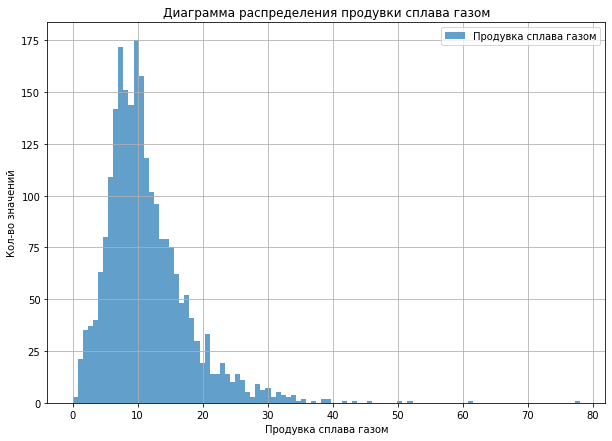

In [116]:
full_data['gas_1'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
plt.xlabel("Продувка сплава газом");
plt.ylabel("Кол-во значений");
plt.legend(['Продувка сплава газом']);
plt.title("Диаграмма распределения продувки сплава газом");

Распределение продувки сплава газом имеет почти нормальное распределение с небольшим скосом.

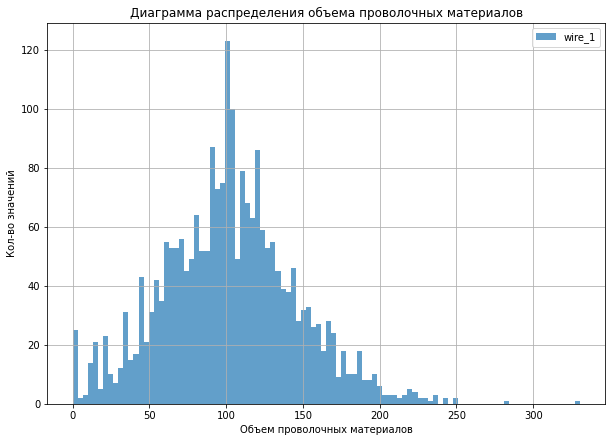

In [117]:
full_data['wire_1'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
plt.xlabel("Объем проволочных материалов");
plt.ylabel("Кол-во значений");
plt.legend(['wire_1']);
plt.title("Диаграмма распределения объема проволочных материалов");

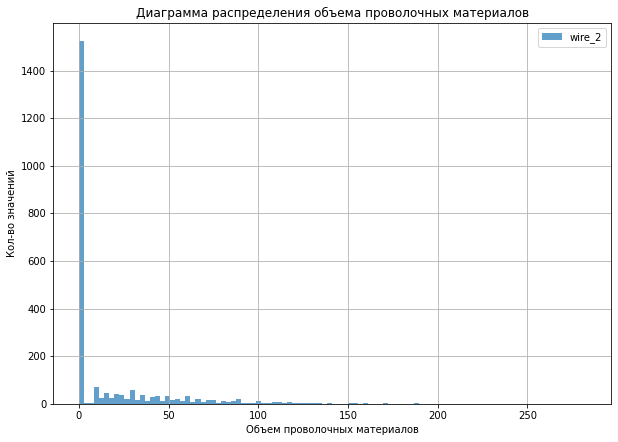

In [118]:
full_data['wire_2'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
plt.xlabel("Объем проволочных материалов");
plt.ylabel("Кол-во значений");
plt.legend(['wire_2']);
plt.title("Диаграмма распределения объема проволочных материалов");

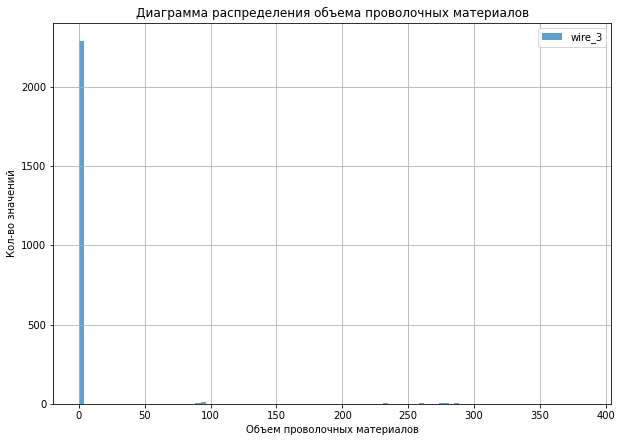

In [119]:
full_data['wire_3'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
plt.xlabel("Объем проволочных материалов");
plt.ylabel("Кол-во значений");
plt.legend(['wire_3']);
plt.title("Диаграмма распределения объема проволочных материалов");

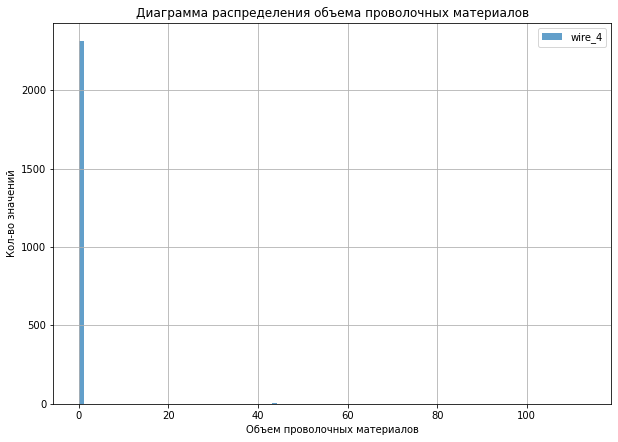

In [120]:
full_data['wire_4'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
plt.xlabel("Объем проволочных материалов");
plt.ylabel("Кол-во значений");
plt.legend(['wire_4']);
plt.title("Диаграмма распределения объема проволочных материалов");

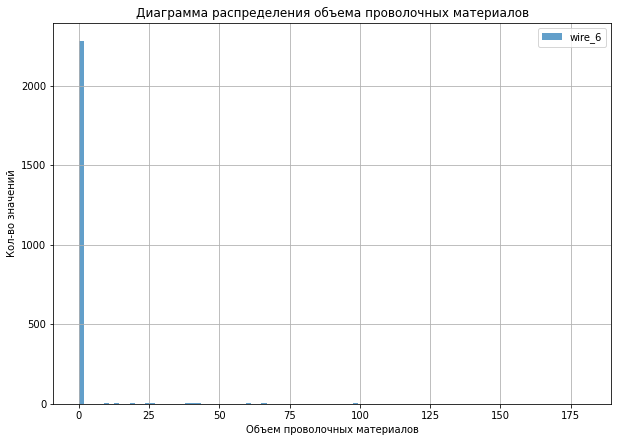

In [121]:
full_data['wire_6'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
plt.xlabel("Объем проволочных материалов");
plt.ylabel("Кол-во значений");
plt.legend(['wire_6']);
plt.title("Диаграмма распределения объема проволочных материалов");

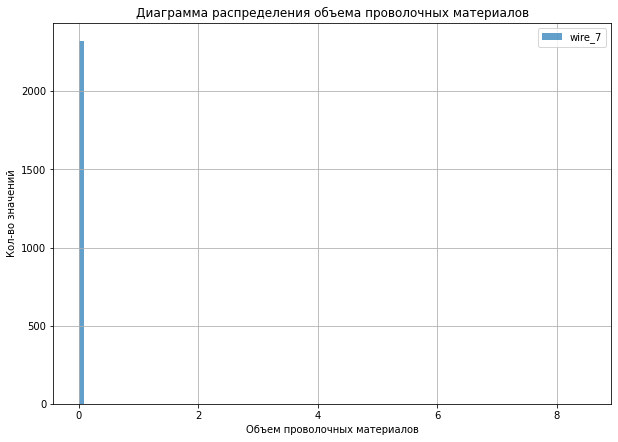

In [122]:
full_data['wire_7'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
plt.xlabel("Объем проволочных материалов");
plt.ylabel("Кол-во значений");
plt.legend(['wire_7']);
plt.title("Диаграмма распределения объема проволочных материалов");

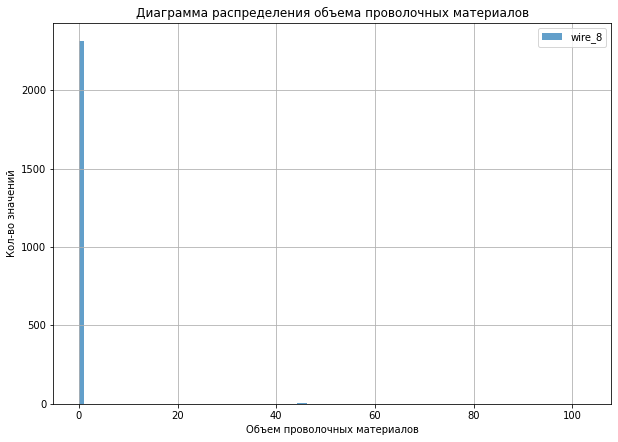

In [123]:
full_data['wire_8'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
plt.xlabel("Объем проволочных материалов");
plt.ylabel("Кол-во значений");
plt.legend(['wire_8']);
plt.title("Диаграмма распределения объема проволочных материалов");

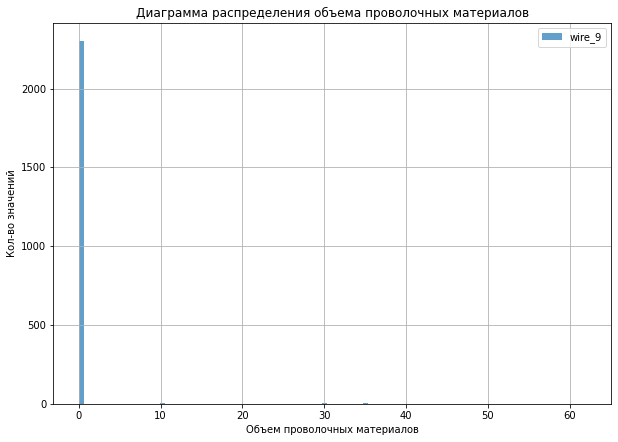

In [124]:
full_data['wire_9'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
plt.xlabel("Объем проволочных материалов");
plt.ylabel("Кол-во значений");
plt.legend(['wire_9']);
plt.title("Диаграмма распределения объема проволочных материалов");

У признаков wire_1 и wire_2 есть много разнообразных значений. У остальных большинство значений нулевые (материалы не добавлялись).

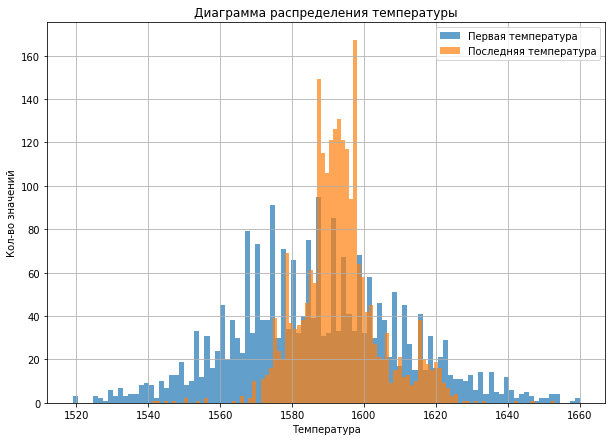

In [125]:
full_data['first_temperature'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
full_data['last_temperature'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
plt.xlabel("Температура");
plt.ylabel("Кол-во значений");
plt.legend(['Первая температура', 'Последняя температура']);
plt.title("Диаграмма распределения температуры");

У начальной температуры большинство значений находятся в диапазоне от 1540 до 1640 градусов. У конечной температуры в диапазоне от 1570 до 1620 градусов.

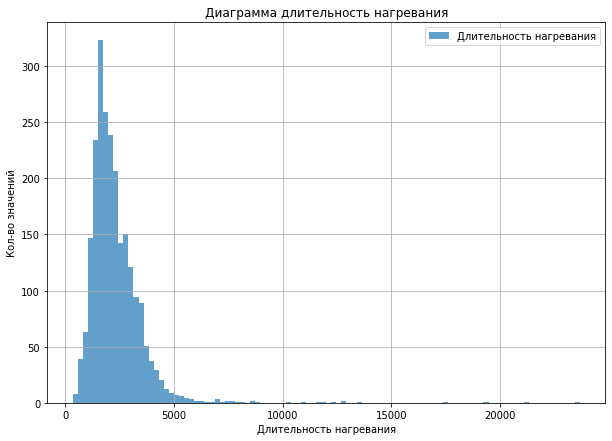

In [126]:
full_data['duration_temp'].hist(figsize=(10,7), alpha=0.7, bins=100, grid=True);
plt.xlabel("Длительность нагревания");
plt.ylabel("Кол-во значений");
plt.legend(['Длительность нагревания']);
plt.title("Диаграмма длительность нагревания");

Распределение нормальное с небольшим скосом.

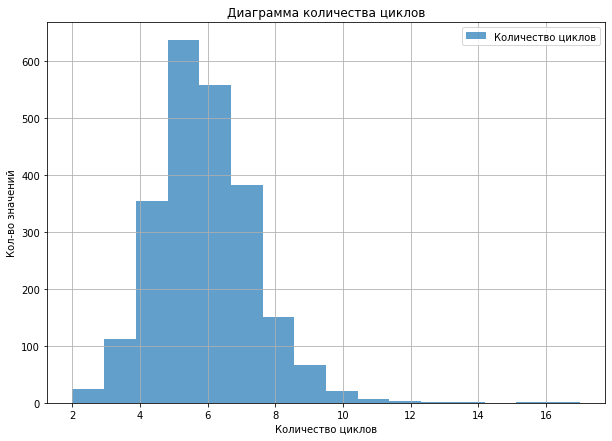

In [127]:
full_data['count_cycle'].hist(figsize=(10,7), alpha=0.7, bins=16, grid=True);
plt.xlabel("Количество циклов");
plt.ylabel("Кол-во значений");
plt.legend(['Количество циклов']);
plt.title("Диаграмма количества циклов");

Распределение нормальное. Самое распространенное число циклов - 4, 5, 6 и 7.

В итоговом датафрейме признаки имеют преимущественно нормальное распределение, за исключением сыпучих и проволчных материалов.

**Промежуточные выводы**

Мы провели предобработку данных: устранили пропуски, избавились от аномалий, агрегировали данные по ключу. Затем собрали данные в одну таблицу, построили матрицу корреляций, изучили по ней мультиколлинеарность. Отбросили незначимые признаки.

Также мы провели графический анализ итогового датафрейма, который показал, что признаки имеют преимущественно нормальное распределение, за исключением сыпучих и проволчных материалов.

## Построение модели

### Разделение на выборки и масштабирование признаков

In [128]:
features = full_data.drop('last_temperature', axis=1)
target = full_data['last_temperature']

print(features.shape)
print(target.shape)

(2324, 31)
(2324,)


In [129]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, \
                                                                          random_state=RANDOM_STATE)

print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(1743, 31)
(581, 31)
(1743,)
(581,)


In [130]:
#масштабируем данные
scaler = StandardScaler()
scaler.fit(features_train)
features_train_scaled = pd.DataFrame(scaler.transform(features_train), columns=features_train.columns)
features_test_scaled = pd.DataFrame(scaler.transform(features_test), columns=features_test.columns)
features_train_scaled.head(5)

,full_power,mean_active_power,mean_reactive_power,sum_duration_arc,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,first_temperature,duration_temp,count_cycle
0,-0.247793,-0.142257,-0.094623,-0.511749,-0.27647,-0.079247,0.700003,-0.63463,-0.120186,-0.405866,...,1.834594,-0.124438,-0.067924,-0.111266,-0.035756,-0.06811,-0.098174,-0.727892,-0.648524,-0.459394
1,-1.065749,-1.371673,-1.395963,-0.128449,-0.27647,-0.079247,-0.634653,-0.63463,-0.120186,-0.405866,...,0.654481,-0.124438,-0.067924,-0.111266,-0.035756,-0.06811,-0.098174,0.162941,0.933834,0.166172
2,1.359446,0.255695,0.135358,0.296131,-0.27647,-0.079247,0.160748,-0.63463,-0.120186,0.806019,...,-0.530082,-0.124438,-0.067924,-0.111266,-0.035756,-0.06811,-0.098174,1.053774,0.561954,2.042869
3,-0.381278,-0.960475,-0.644545,0.590977,-0.27647,-0.079247,-0.634653,1.59046,-0.120186,-0.405866,...,-0.530082,-0.124438,-0.067924,-0.111266,-0.035756,-0.06811,-0.098174,1.265877,1.055554,0.166172
4,-0.107778,-0.630588,-0.577112,0.478935,-0.27647,-0.079247,-0.634653,2.46338,-0.120186,-0.405866,...,-0.530082,-0.124438,-0.067924,-0.111266,-0.035756,-0.06811,-0.098174,0.162941,0.446955,0.791737


In [131]:
features_test_scaled.head(5)

,full_power,mean_active_power,mean_reactive_power,sum_duration_arc,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,first_temperature,duration_temp,count_cycle
0,-1.013651,-1.729602,-1.780530,0.664689,-0.27647,-0.079247,1.508886,-0.63463,-0.120186,-0.405866,...,5.972109,-0.124438,-0.067924,-0.111266,-0.035756,-0.06811,-0.098174,-0.685472,-0.096677,0.791737
1,1.331316,-0.149972,-0.447400,2.575295,-0.27647,-0.079247,-0.243694,-0.63463,-0.120186,5.746780,...,-0.530082,-0.124438,-0.067924,-0.111266,-0.035756,-0.06811,-0.098174,-0.134003,7.799428,2.042869
2,0.752468,0.754102,1.060879,-0.644430,-0.27647,-0.079247,0.362969,-0.63463,-0.120186,-0.405866,...,1.895696,-0.124438,-0.067924,-0.111266,-0.035756,-0.06811,-0.098174,1.393139,-0.142976,0.166172
3,0.902127,1.208830,1.524938,-0.278820,-0.27647,-0.079247,-0.634653,-0.63463,-0.120186,-0.405866,...,-0.530082,-0.124438,-0.067924,-0.111266,-0.035756,-0.06811,-0.098174,-0.812734,-0.936021,-0.459394
4,-0.111010,-0.374156,0.005074,-0.098964,-0.27647,-0.079247,-0.634653,-0.63463,-0.120186,2.670457,...,-0.530082,-0.124438,-0.067924,-0.111266,-0.035756,-0.06811,-0.098174,0.544727,0.170658,0.166172


In [132]:
print(features_train_scaled.shape)
print(features_test_scaled.shape)
print(target_train.shape)
print(target_test.shape)

(1743, 31)
(581, 31)
(1743,)
(581,)


### Построение моделей

#### Константная модель

In [133]:
dummy_model = DummyRegressor(strategy="median")
%time dummy_model.fit(features_train_scaled, target_train)
%time dummy_predict = dummy_model.predict(features_test_scaled)
dummy_mae = mean_absolute_error(target_test, dummy_predict)
print('Медианная предсказанная температура:', pd.Series(dummy_predict).median())
print('MAE:', dummy_mae)

CPU times: user 781 µs, sys: 82 µs, total: 863 µs
Wall time: 722 µs
CPU times: user 211 µs, sys: 22 µs, total: 233 µs
Wall time: 181 µs
Медианная предсказанная температура: 1593.0
MAE: 7.629948364888124


#### Линейная модель

In [134]:
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

In [135]:
linear_features_train_scaled = features_train_scaled.drop('bulk_9', axis=1)

In [136]:
linear_model = LinearRegression()
linear_parameters = {'fit_intercept': [True, False], \
                     'normalize':[True, False]}

linear_grid = GridSearchCV(linear_model, \
                           param_grid=linear_parameters, \
                           scoring=mae_scorer, \
                           n_jobs=-1, \
                           cv=10)

features_temp = features_train_scaled.sample(100).reset_index(drop=True)
target_temp = target_train.sample(100).reset_index(drop=True)


In [137]:
%%time
linear_grid.fit(features_temp, target_temp)

CPU times: user 162 ms, sys: 107 µs, total: 162 ms
Wall time: 161 ms


GridSearchCV(cv=10, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [138]:
%%time
linear_grid.fit(features_train_scaled, target_train)

CPU times: user 1.42 s, sys: 1.62 s, total: 3.05 s
Wall time: 3.01 s


GridSearchCV(cv=10, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [139]:
print(linear_grid.best_params_)
print(linear_grid.best_score_)

{'fit_intercept': True, 'normalize': True}
-6.01557833832969


#### Модель градиентного бустинга CatBoost

In [140]:
CatBoost_model = CatBoostRegressor()
CatBoost_parameters = {'iterations': [500, 700, 1000], \
                       'learning_rate': [0.01, 0.03, 0.05], \
                       'verbose':[100]}

CatBoost_grid = GridSearchCV(CatBoost_model, \
                           param_grid=CatBoost_parameters, \
                           scoring=mae_scorer, \
                           n_jobs=-1, \
                           cv=5)

In [141]:
%%time
CatBoost_grid.fit(features_train_scaled, target_train)

0:	learn: 11.3356032	total: 56.3ms	remaining: 28.1s
100:	learn: 9.5327341	total: 382ms	remaining: 1.51s
200:	learn: 8.6568103	total: 698ms	remaining: 1.04s
300:	learn: 8.1229205	total: 1.06s	remaining: 701ms
400:	learn: 7.7340260	total: 1.4s	remaining: 346ms
499:	learn: 7.4208546	total: 1.73s	remaining: 0us
0:	learn: 11.3668267	total: 3.9ms	remaining: 1.94s
100:	learn: 9.4930671	total: 330ms	remaining: 1.3s
200:	learn: 8.6005728	total: 679ms	remaining: 1.01s
300:	learn: 8.0584374	total: 1.04s	remaining: 690ms
400:	learn: 7.6604225	total: 1.38s	remaining: 341ms
499:	learn: 7.3243155	total: 1.75s	remaining: 0us
0:	learn: 11.5309098	total: 3.95ms	remaining: 1.97s
100:	learn: 9.5405572	total: 330ms	remaining: 1.3s
200:	learn: 8.6024730	total: 660ms	remaining: 982ms
300:	learn: 8.0617301	total: 977ms	remaining: 646ms
400:	learn: 7.6582530	total: 1.3s	remaining: 321ms
499:	learn: 7.3433234	total: 1.63s	remaining: 0us
0:	learn: 11.1487579	total: 3.6ms	remaining: 1.8s
100:	learn: 9.3242160	tot

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f0bd1b94700>,
             n_jobs=-1,
             param_grid={'iterations': [500, 700, 1000],
                         'learning_rate': [0.01, 0.03, 0.05],
                         'verbose': [100]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [142]:
print(CatBoost_grid.best_params_)
print(CatBoost_grid.best_score_)

{'iterations': 700, 'learning_rate': 0.03, 'verbose': 100}
-5.928273285011761


**Промежуточные выводы**

Константная модель показала MAE 7,63.

На линейной модели мы получили MAE 6,02.

С помощью CatBoost мы достигли MAE 5,93.

CatBoost показала лучший результат, выберем эту модель.

## Тестирование модели

In [143]:
predicted = CatBoost_grid.predict(features_test_scaled)
mae = mean_absolute_error(target_test, predicted)
mae

5.552377091452061

На тестовой выборке мы получили MAE равное 5,55. 

In [144]:
CatBoost_grid.best_estimator_

In [145]:
signs_data = CatBoost_grid.best_estimator_.feature_importances_
pd.Series(signs_data).sort_values()

11     0.000000
26     0.001083
12     0.003736
16     0.016612
27     0.017617
5      0.031729
25     0.033424
8      0.093262
22     0.247700
24     0.395920
13     0.400470
14     0.587749
7      0.705377
30     0.785883
23     0.795680
6      1.142053
1      1.703291
2      1.770065
10     1.908789
19     2.086049
0      2.120806
4      2.128101
17     3.561823
15     3.595672
18     3.793544
9      3.858979
21     4.339849
20     6.553626
29     9.295220
28    22.619474
3     25.406418
dtype: float64

Самыми важными признаками для модели оказались: общее время включения электродов, начальная температура и общее время плавки.

## Выводы

В ходе решения задачи была проделана следующая работа:

**1. Проведен исследовательский анализ данных:**
   - проведен обзор данных;
   - для каждого признака построена диаграмма размаха;
   - исследованы пропуски и аномалии;
   - определены необходимые для дальнейшей работы датафреймы.
   
   По итогу исследовательского анализа мы выяснили что требуется обработка пропусков, необходимо переименовать столбцы и требуется обработка аномалий.
   
**2. Проведена предобработка данных:**
   - устранены аномалии и пропуски;
   - сгенерированы новые признаки: полная мощность, средняя активная и реактивная мощность, общее время включения электродов, количество циклов, время плавки;
   - проведена агрегация внутри датафреймов по ключу;
   - все данные объеденены в один итоговый датафрейм по ключу;
   - данные исследованы на мультиколлинеарность;
   - проведен исследовательский анализ признаков итогового датафрейма.
   
   По итогу предобработки данных мы получили чистый датафрейм для построения модели. По матрице корреляций, изучена мультиколлинеарность признаков, отброшены незначимые признаки. Графический анализ распределения признаков показал, что признаки имеют преимущественно нормальное распределение, за исключением сыпучих и проволчных материалов.
   
**3. Построение модели:**
   - Константная модель, основанная на медианном значении температуры, показала MAE 7,63;
   - Линейная модель построена с помощью GridSearchCV с cv = 5, с параметрами fit_intercept = True, normalize = True показала MAE 6,02;
   - Модель градиентного бустинга CatBoost построена с помощью GridSearchCV с cv = 5, с параметрами iterations = 700, learning_rate = 0.03 показала MAE 5,93.
   
   CatBoost показала лучший результат, поэтому мы выбрали ее в качестве лучшей модели для тестирования.
   
**4. Тестирование модели:**
   - На тестовой выборке мы получили MAE равное 5,55.
   - Самыми важными признаками для модели оказались: общее время включения электродов, начальная температура и общее время плавки.
   
   Нам удалось достичь цель проекта: мы построили модель, предсказывающую последнюю температуру стали. Нам удалось достичь MAE < 6.8.

## Отчет

### Сравнение решения и плана

План выплнения проекта был следующий:

**1. Провести исследовательский анализ данных.** Посмотреть на содержимое датасетов, выявить аномалии, пропуски, определить, какие правки потребуются.

**2. Провести предобработку данных.** Исправить названия столбцов, обработать пропуски, устранить аномалии. Определить признаки, которые влияют на последнюю температуру и подготовить общую таблицу со всеми необходимыми признаками для обучения модели.

**3. Построение модели.** Обучение разных моделей и оценка их качества, выбор лучшей модели.

**4. Тестирование модели.** Проверить качество лучшей модели на тестовой выборке.

**5. Подготовка отчета.** Описать проделанную работу и полученные результаты.

Все пункты плана соответствуют итоговому решению. Отличие заключается лишь в том, что в решении появились дополнительные подпункты в основных этапах. Так, в предобработке данных помимо всего, что указано в плане, мы сгенерировали новые признаки для модели, т.к. с существующим набором признаков достичь значения MAE < 6.8 не удалось. Также мы провели исследовательский анализ итогового датафрейма: построили матрицу корреляций для исследования мультиколлинеарности признаков, и рассмотрели графики распределения признаков. Исследовательский анализ просто не был указан в плане, но проводить его мы в любом случае собирались.

Пункт "построение модели" соответствует решению, мы построили константную модель, модель линейной регресии и модель градиентного бустинга CatBoost. Из них мы выбрали лучшую.

В пункте "тестирование модели" мы также провели исследование важности признаков. Этот подпункт не был указан в плане, но мы планировали его включать в решение. 

### Описание трудностей проекта

Главное затруднение, с которым мы столкнулись в проекте, это достижение MAE < 6,8. С исходным набором признаков, нам не удалось получить нужную метрику, поэтому мы дополнительно сгенерировали новые признаки: вычислили полную мощность при включении электродов, общее время включения электродов, среднюю активную и реактивную мощность, общее время варки и количество циклов.

Также возникли некоторые трудности с масштабированием данных, использованием GridSearchCV, выбором гиперпараметров для модели CatBoost и вычислении важности признаков для итоговой модели. Эти трудности были связаны с отсутствием большого опыта в использовании этих инструментов.

### Ключевые шаги решения

#### Предобработка данных

Во всех датафреймах мы переименовали столбцы в соответсвии с общепринятым стилем именования.

**Данные об электродах**

В данных об электродах встретилась аномалии в столбце "Реактивная мощность", мы обнаружили отрицательные значения. Мы удалили партии, в которых встречались отрицательные значения.

Также мы ввели новый столбец "Полная мощность", которую вычислили по формуле: sqrt((акт. мощн.)^2 + (реакт. мощн.)^2).

Еще мы вычислили общее время включения электродов (в секундах). Для этого мы вычислили время включения электродов каждого цикла, а затем группировкой по номеру партии просуммировали эти длительности.

Также мы добавили столбец со средней активной и реактивной мощность по партии.

Исходная таблица:

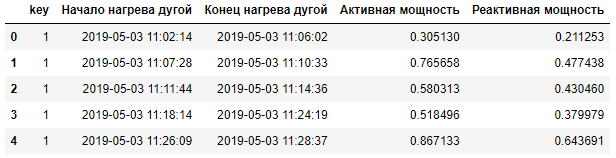

Таблица после предобработки:

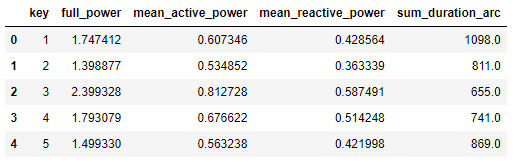

**Данные о подаче сыпучих материалов**

В данных об объеме добавленных сыпучих материалов в сплав мы обнаружили много пропусков, т.к. определенные материалы не добавлялись в партии. Эти пропуски мы заполнили нулями.

Таблица не требевола агрегации по номеру партии, т.к. все значения были уникальны.

Исходня таблица:

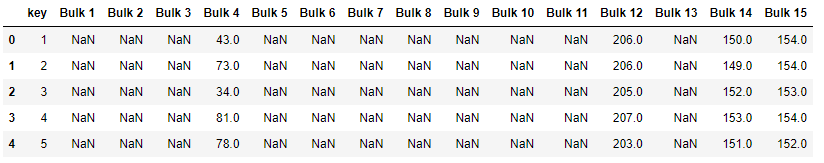

Таблица после предобработки:

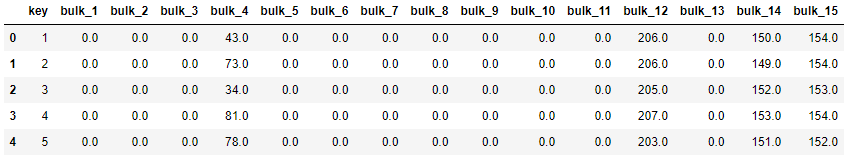

**Данные о продувке сплава газом**

В данных о продувке сплава газом мы только изменили название столбца. Пропусков не было, и агрегация по номеру партии не требовалась, т.к. все значения были уникальны.

**Данные о проволочных материалах**

В данных об объеме поданных проволочных материалов было много пропусков. Аналогично данным об объеме добавленных сыпучих материалов, мы хаменили пропуски нулями. агрегация не требоволась.

Исходная таблица:

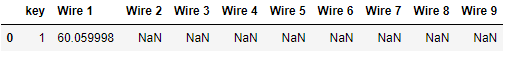

Таблица после предобработки:

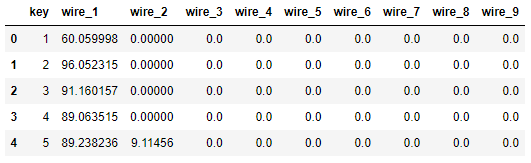

**Результаты измерения температуры**

В данных об измерении температуры были пропуски. Восстановить их было нелья, поэтому мы удалили все партии с пропусками.

Также присутствовали аномально низкие значения температуры (ниже 1450 градусов), партии с ними мы удалили.

Еще мы избавились от партий с одним замером.

В итоговой таблице мы оставили только первый и последний замер температуры, общее время замеров температуры (рассчитывали аналогично общему времени включения электродов (в секундах)) и количество циклов в партии.

Исходная таблица:

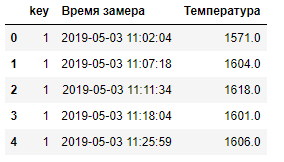

Таблица после предобработки:

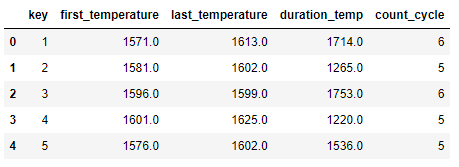

#### Объединение данных в один датафрейм

Все предобработанные датафреймы мы последовательно объединили в итоговый по номеру партии (поле 'key') с объединением 'inner'.

Итак, мы получили итоговый датафрейм с 2324 записями и 34 столбцами.

Объединенный датафрейм: 

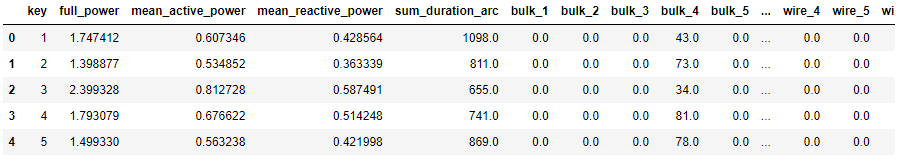

#### Исследовательский анализ итогового датафрейма

Мы построили матрицу корреляций:

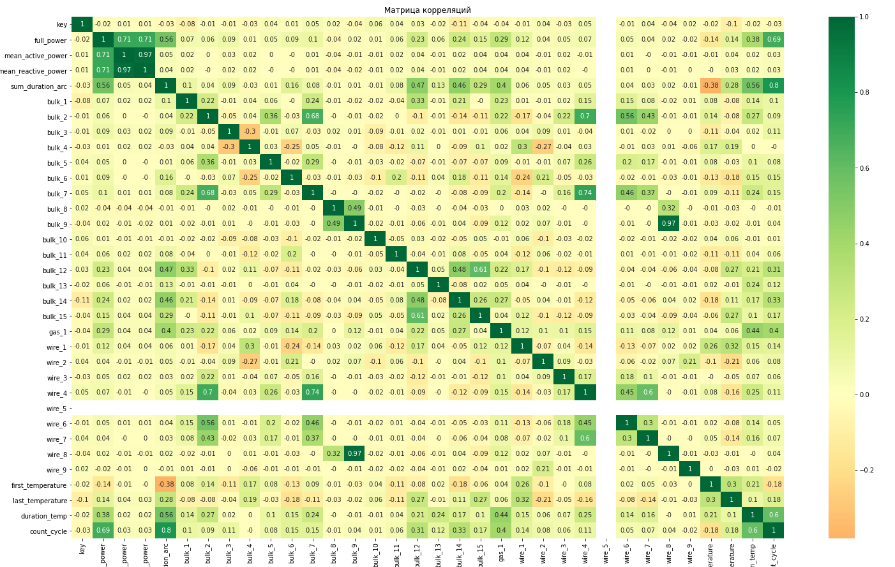

Она показала что у признаков bulk 9 и wire 8 корреляция доходит до 0.97, поэтому далее мы исключили признак bulk 9 для линейной модели.

Также мы исключили признак wire 5, т.к. он не имеет значимости для модели (в данных всего 1 значение). И исключили значение ключа, т.к. оно для модели не важно.

### Обучение моделей, выбор лучшей и её тестирование

итоговый датафрейм мы разделили на обучающую и тестовую выборку в соотношении 75:25, с random_state=250923.

Мы построили 3 модели: константную, модель линейной регресии и модель градиентного бустинга CatBoost.

Константная модель построена с помощью DummyRegressor с медианным значением целевого признака. MAE константной модели составила: 7,63.

Для модели линейной регресии мы исключили признак bulk_9. Для подбора лучших гиперпараметров мы использовали GridSearchCV с cv=10. Гиперпараметры, которые мы подбирали - это fit_intercept со значениями True и False и normalize со значениями True и False. MAE модели линейной регресии составила: 6,02.

Для подбора лучших гиперпараметров модели градиентного бустинга CatBoost мы использовали GridSearchCV с cv=5. Гиперпараметры, которые мы подбирали - это iterations со значениями 500, 700, 1000 и learning_rate со значениями 0.01, 0.03, 0.05. MAE модели градиентного бустинга CatBoost составила: 5,93.

Лучший результат показала модель градиентного бустинга CatBoost, ее мы и выбрали для тестирования. На тестовой выборке мы получили MAE равное 5,55.

### Полное описание модели

**Лучшая модель:** модель градиентного бустинга CatBoost.

**Гиперпараметры модели:** iterations = 700, learning_rate = 0.03.

Гиперпараметр verbose мы установили равным 100.

**Значение целевой метрики (MAE) на обучающей выборке:** 5,93.

**Значение целевой метрики (MAE) на тестовой выборке:** 5,55.

**Самые важные признаки лучшей модели**: общее время включения электродов - 25.4%, начальная температура - 22.6% и общее время плавки - 9.3%.

### Итоговая метрика

Итоговая метрика (MAE) на тестовой выборке составила: **5,55**.

Нам удалось достичь целевого значения метрики MAE (<6,8).

### Рекомендации по улучшению решения

1. Собрать больше данных в целом.
2. Собрать больше примеров с добавление различных сыпучих метериалов, т.к. в текущем датасете есть 15 различных материалов, но данных достаточно только в 6 из них.
3. Собрать больше примеров с добавление различных проволочных метериалов, т.к. в текущем датасете есть 9 различных материалов, но данных достаточно только в 2 из них.
4. Собрать новые признаки, если такие имеются.
5. Попробовать другие модели.
6. Попробовать улучшить модель градиентного бустинга CatBoost. Можно перебрать больше вариантов итераций. В текущем варианте мы рассматривали значения 500, 700 и 1000. Можно рассмотреть больше значений в этом же диапазоне. То же самое можно проделать со скоростью обучения. Сейчас это значения 0.01, 0.03, 0.05. Можно рассмотреть больше значений в этом же диапазоне. Также можно попробовать расмотреть другие гиперпараметры.